Restructuring inspired by [photometry_from_aec_emulator.ipynb](photometry_from_aec_emulator.ipynb) and some discussion w/ Michelle.

In [1]:
import time
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np

from scipy import integrate

from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.modeling import models, fitting

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [3]:
phottab = table.Table.read('spectrophotometry.ecsv', format='ascii.ecsv')
phottab.colnames

['specname',
 'absmag_F275W_vega',
 'absmag_F275W_AB',
 'absmag_F275W_ST',
 'absmag_F336W_vega',
 'absmag_F336W_AB',
 'absmag_F336W_ST',
 'absmag_F475W_vega',
 'absmag_F475W_AB',
 'absmag_F475W_ST',
 'absmag_F814W_vega',
 'absmag_F814W_AB',
 'absmag_F814W_ST',
 'absmag_F110W_vega',
 'absmag_F110W_AB',
 'absmag_F110W_ST',
 'absmag_F160W_vega',
 'absmag_F160W_AB',
 'absmag_F160W_ST']

In [4]:
phottensors = []
bandnms = 'F275W,F336W,F475W,F814W,F110W,F160W'.split(',')
for bandnm in bandnms:
    phottensors.append(torch.from_numpy(phottab[f'absmag_{bandnm}_AB']))
    
phottensors = torch.vstack(phottensors).T.to(device, dtype=tensor_dtype)
phottensors.shape

torch.Size([7508, 6])

In [5]:
scaled_phottensors = ((phottensors-phottensors.mean(0))/phottensors.std(0))

In [6]:
datapath = Path('../fullgrid/')

In [7]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

In [8]:
goodspecmask = np.array(['BUNIT' in fits.getheader(p) for p in tqdm(allspecpaths)])
goodspecpaths = [p for i,p in enumerate(allspecpaths) if goodspecmask[i]]
assert len(goodspecpaths) == np.sum(goodspecmask)

  0%|          | 0/7559 [00:00<?, ?it/s]

In [9]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in goodspecpaths])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in goodspecpaths])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in goodspecpaths])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

In [10]:
class PhotEmulator(nn.Module):
    def __init__(self, feature_mlp_nneurons, phot_nneurons, teffindex=0, 
                       logifyteff=False,activation_cls=nn.GELU, batchnorm=False):
        super().__init__()


        self.teffindex = teffindex
        self.logifyteff = logifyteff
        
        noutpixels = phot_nneurons[-1]

        mlp_layers = []
        if batchnorm == 'first':
            mlp_layers.append(nn.BatchNorm1d(feature_mlp_nneurons[0]))
        for ni, no in zip(feature_mlp_nneurons[:-1], feature_mlp_nneurons[1:]):
            mlp_layers.append(nn.Linear(ni, no))
            if batchnorm and (batchnorm != 'first'):
                mlp_layers.append(nn.BatchNorm1d(no))
            mlp_layers.append(activation_cls())


        self.mlp = nn.Sequential(*mlp_layers)

        assert feature_mlp_nneurons[-1] == phot_nneurons[0], 'the mlp must end with the same number of neurons as the phot net starts with!' 

        
        phot_layers = []
        for ni, no in zip(phot_nneurons[:-1], phot_nneurons[1:]):
            phot_layers.append(nn.Linear(ni, no))
            phot_layers.append(activation_cls())
        del phot_layers[-1] # last layer should have no activation
        self.photnet = nn.Sequential(*phot_layers)

        self.optimizer_cls = torch.optim.AdamW
        self.scheduler_init = None

        self.loss_fcn = nn.MSELoss()

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype


    def convert_input(self, t):
        t = torch.atleast_2d(t)
        return t.to(self.device, dtype=self.dtype)

    def forward(self, x, in_convert=True):
        """
        the output is not descaled here, use `forward_descale` if that's what's desired
        """
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.clone()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])
    
        ym = self.mlp(x)
        return self.photnet(ym)

    def train_and_validate(self, infeatures, phot, nepochs, batch_size,
                                 tetrsplit=[.3, .7], split_seed=42, optkwargs={}, shuffle_batches=True):
        inteff = infeatures[..., self.teffindex][..., None]
        dataset = TensorDataset(self.convert_input(infeatures), phot)
        
        split_data = random_split(dataset, tetrsplit, torch.Generator().manual_seed(split_seed))
        valid_data, train_data = split_data

        optimizer = self.optimizer_cls(self.parameters(), **optkwargs)
        if self.scheduler_init is not None:
            scheduler = self.scheduler_init(optimizer)
            
        niters = 0
        valid_losses = []
        valid_niters = []    
        train_losses = []
        train_niters = []
        lrs = []

        valid_x = valid_data.dataset.tensors[0][valid_data.indices]
        valid_ys = valid_data.dataset.tensors[1][valid_data.indices]
        def validation_fcn():
            self.eval()
            with torch.no_grad():
                pred = self(valid_x, in_convert=False)
                valid_loss = self.loss_fcn(pred, valid_ys).item()
                valid_losses.append(valid_loss)
                valid_niters.append(niters)
            return valid_loss

        for _ in (pbar := tqdm(range(nepochs))):
            self.train()

            for data in DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_batches):
                X, Y = data[:2]
                optimizer.zero_grad()
                
                pred = self(X, in_convert=False)
                loss = self.loss_fcn(pred, Y)
                
                loss.backward()
                optimizer.step()
        
                niters += X.shape[0]
                
                train_losses.append(loss.item())
                train_niters.append(niters)

            if self.scheduler_init is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
            valid_loss = validation_fcn()
            if self.scheduler_init  is None:
                pbar.set_description(f'valid loss={valid_loss:.3e}')
            else:
                pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')

        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data
        

In [ ]:
1/0 # to not over-write results

5.09439 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

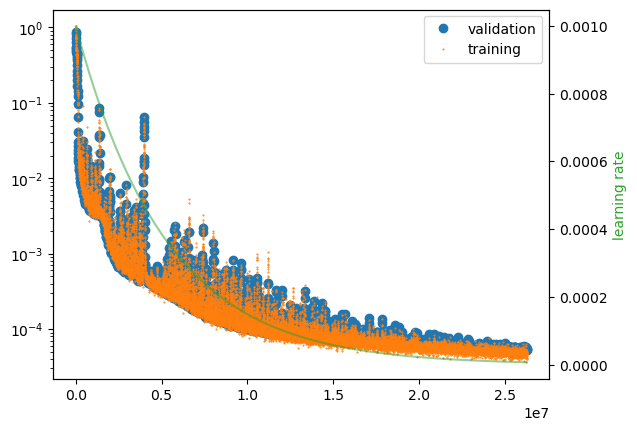

In [16]:
nperrestart = 2500
nrestarts = 2

model = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=True)
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=.999)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, scaled_phottensors, nperrestart*nrestarts, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=1e-3, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(0.00015182505), np.float32(0.0072930544))

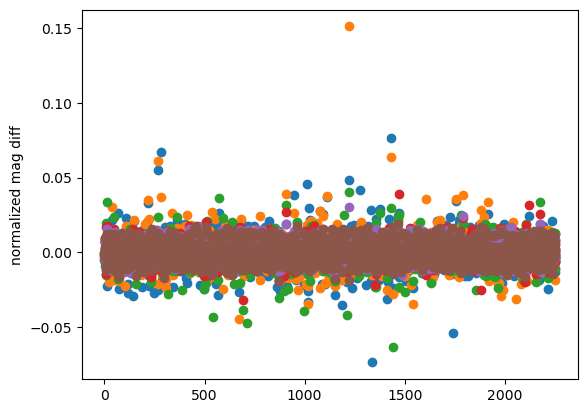

In [17]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')
np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

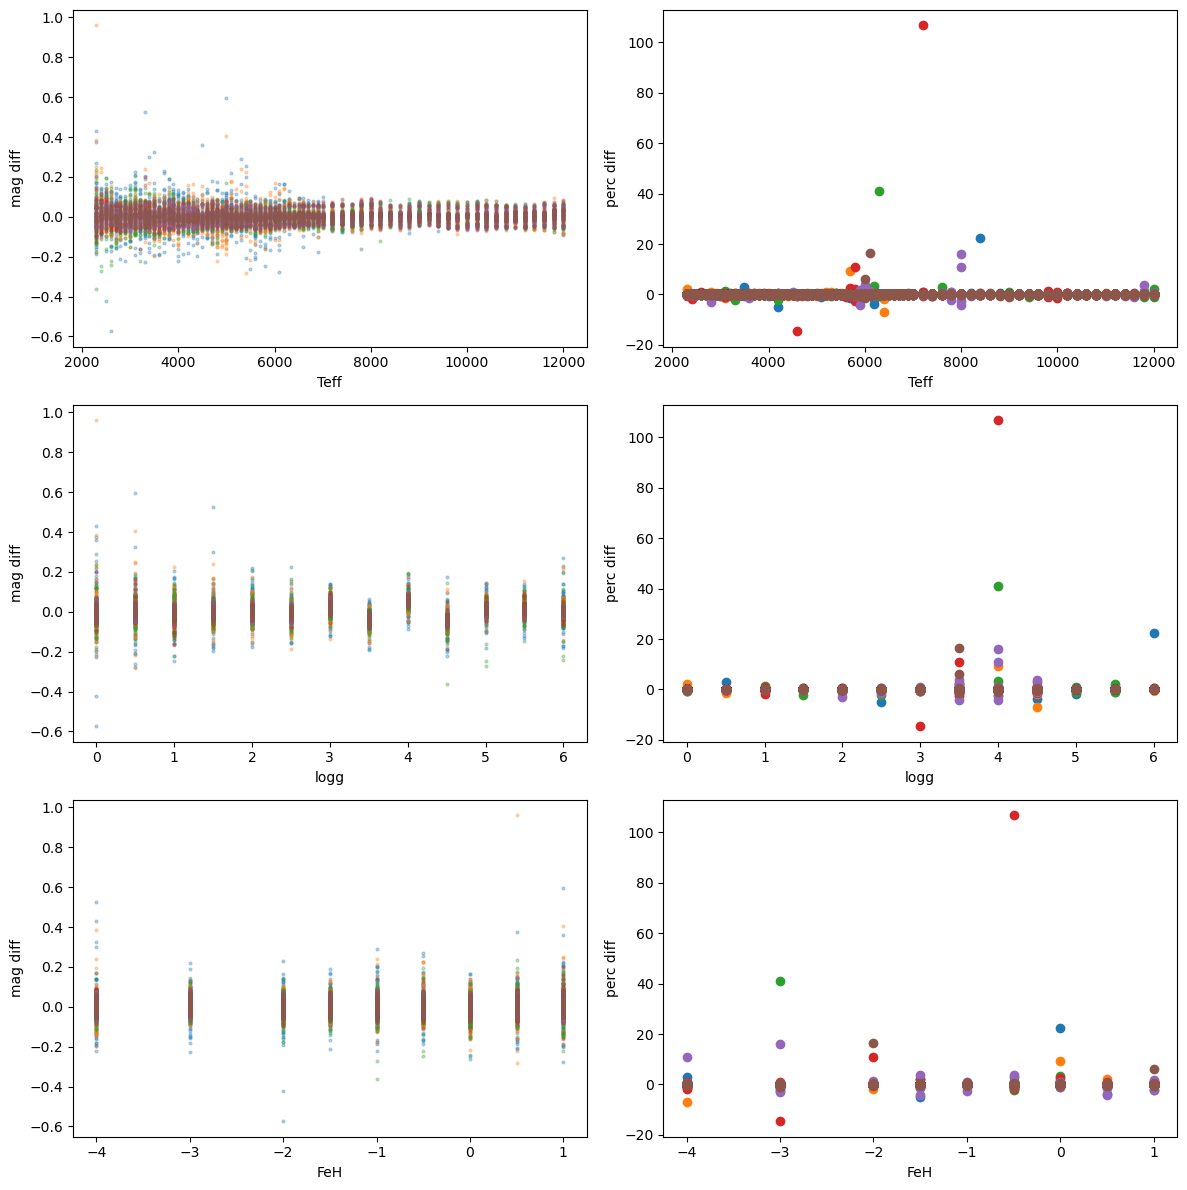

In [18]:
ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

## First layer Batch norm

5.094396 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

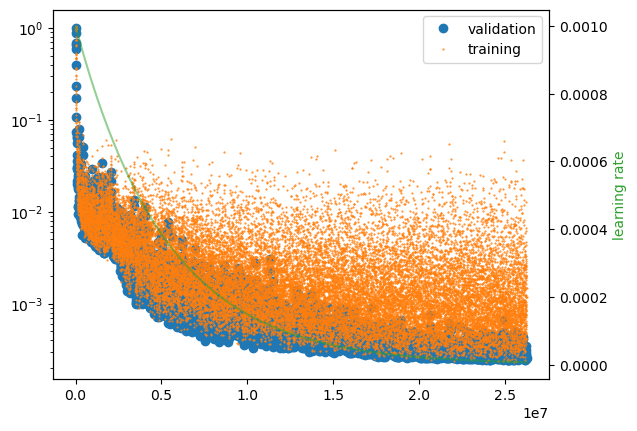

In [19]:
nperrestart = 2500
nrestarts = 2

model2 = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=True, batchnorm='first')
print(sum(p.shape.numel() for p in model2.parameters()) * 1e-6, 'M parameters')

model2 = model2.to(device, dtype=tensor_dtype)

model2.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
model2.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=.999)

valid, train, lrs, data_split =  model2.train_and_validate(infeatures, scaled_phottensors, nperrestart*nrestarts, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=1e-3, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(-0.002813222), np.float32(0.015827022))

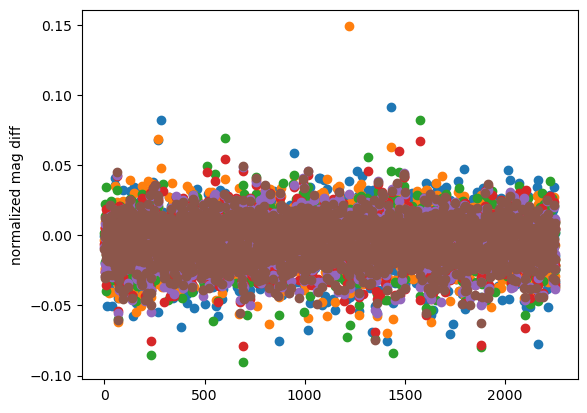

In [20]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model2(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')
np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

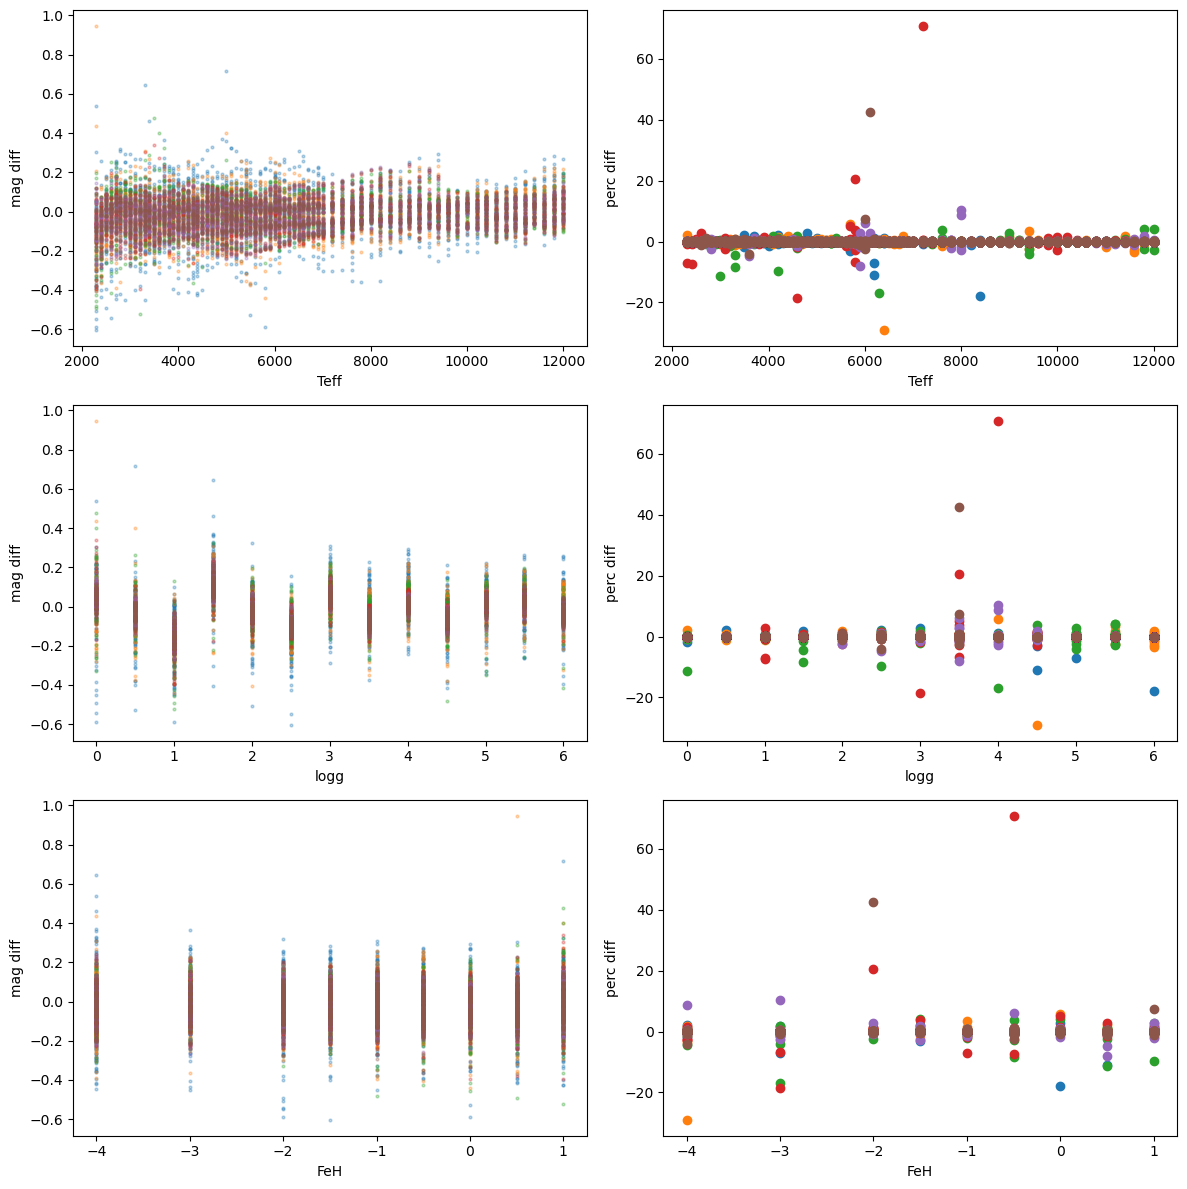

In [21]:
ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

## manual scaling

In [13]:
infeatureslt = infeatures.clone()
#infeatureslt[:, 0] = torch.log10(infeatureslt[:,0])
infeaturesstded = (infeatureslt - infeatureslt.mean(dim=0))/infeatureslt.std(dim=0)

5.09439 M parameters


  0%|          | 0/10000 [00:00<?, ?it/s]

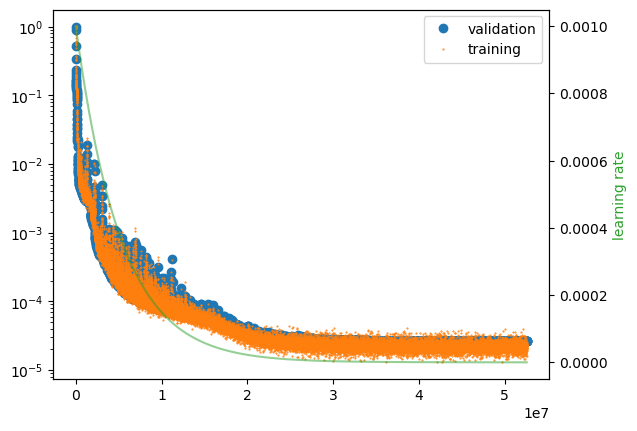

In [56]:
nperrestart = 10000
nrestarts = 1

model3 = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=False, batchnorm=False) # teff can be prelogged if need be above
print(sum(p.shape.numel() for p in model3.parameters()) * 1e-6, 'M parameters')

model3 = model3.to(device, dtype=tensor_dtype)

model3.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
model3.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=.999)

valid, train, lrs, data_split =  model3.train_and_validate(infeaturesstded, scaled_phottensors, nperrestart*nrestarts, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=1e-3, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(-2.1181495e-05), np.float32(0.0051091327))

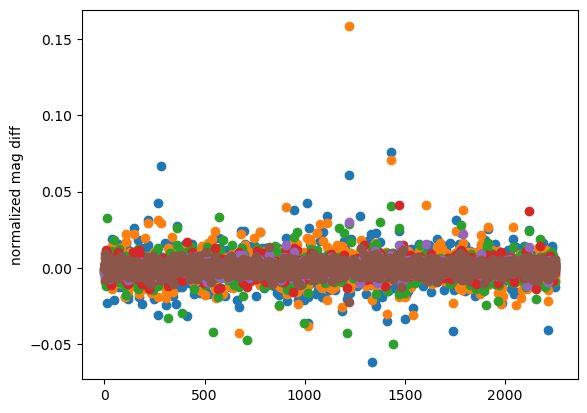

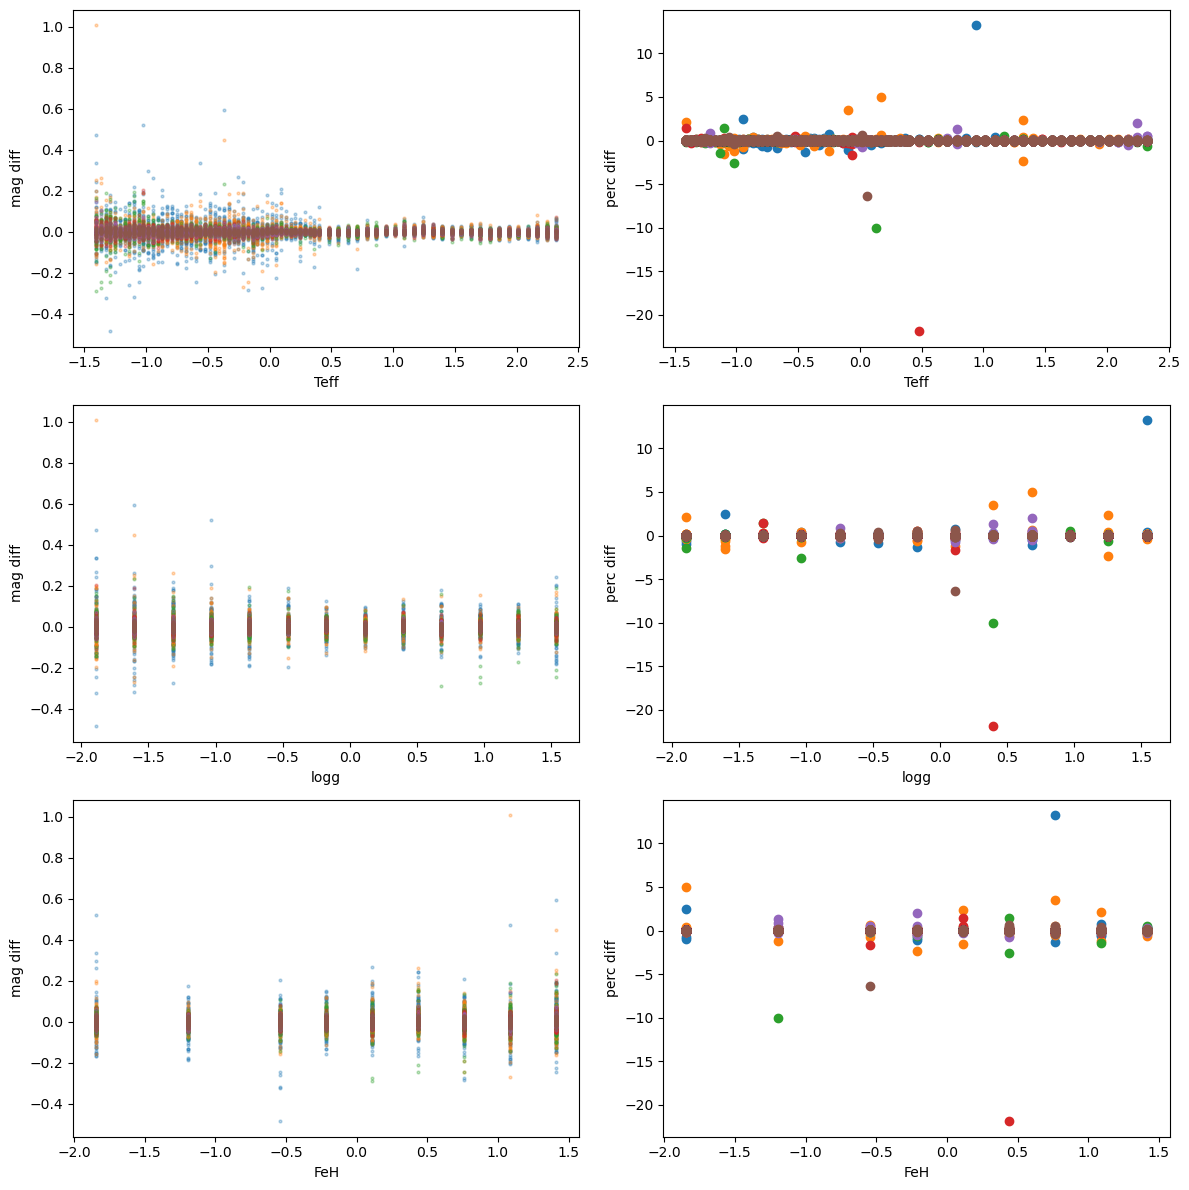

In [57]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model3(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

More explicit LR setting

5.09439 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

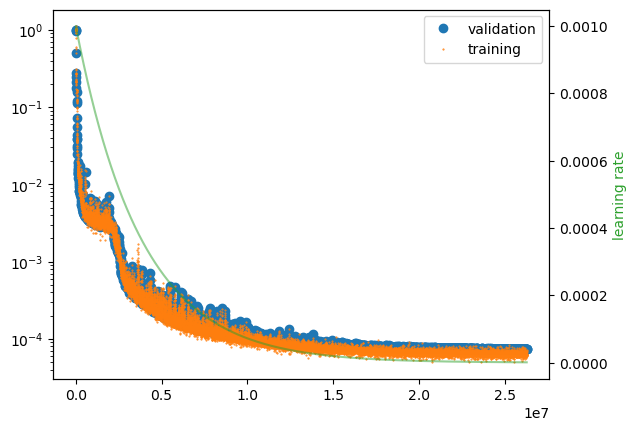

In [69]:
nepochs = 5000
startlr = 1e-3
endlr = 1e-6

model4 = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=False, batchnorm=False) # teff can be prelogged if need be above
print(sum(p.shape.numel() for p in model4.parameters()) * 1e-6, 'M parameters')

model4 = model4.to(device, dtype=tensor_dtype)

gamma = (endlr/startlr)**(1/nepochs)
model4.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)

valid, train, lrs, data_split =  model4.train_and_validate(infeaturesstded, scaled_phottensors, nepochs, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=startlr, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(-0.00029198837), np.float32(0.008598406))

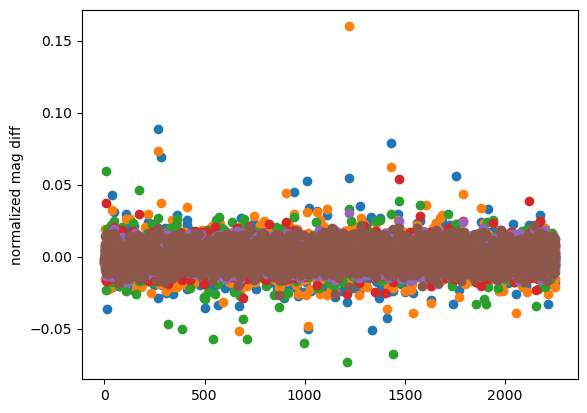

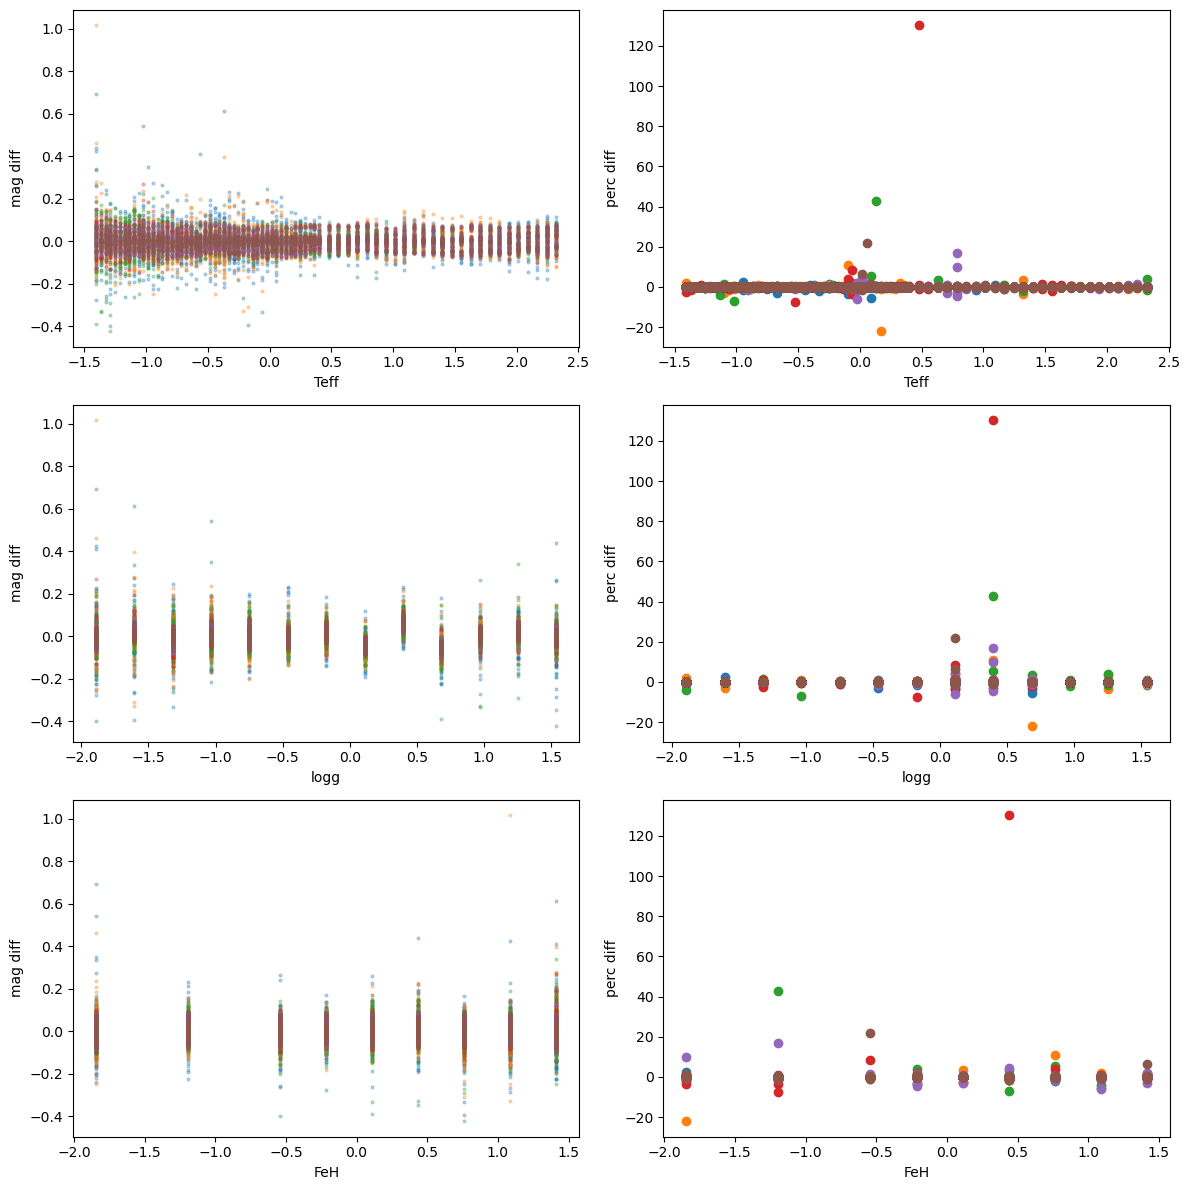

In [70]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model4(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

# Multi-layer batch norm

5.101478 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

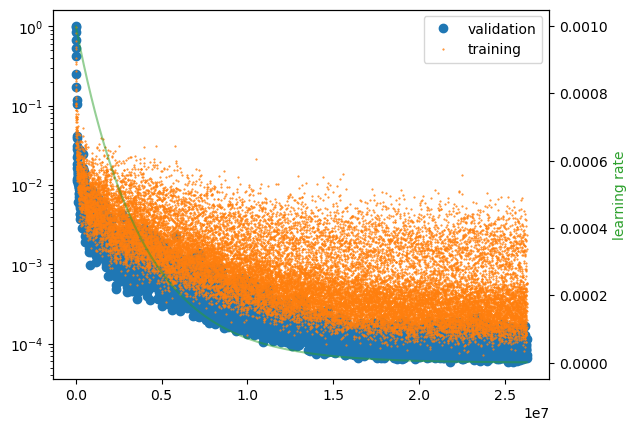

In [17]:
nepochs = 5000
startlr = 1e-3
endlr = 1e-6

model = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=True, batchnorm=True) # teff can be prelogged if need be above
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')
model5 = model

model = model.to(device, dtype=tensor_dtype)

gamma = (endlr/startlr)**(1/nepochs)
model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, scaled_phottensors, nepochs, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=startlr, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(0.00095744285), np.float32(0.008028282))

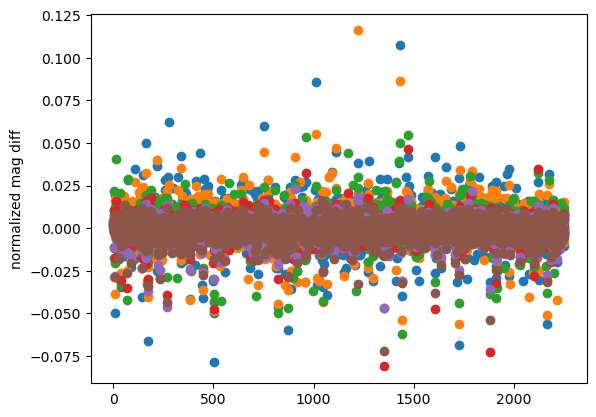

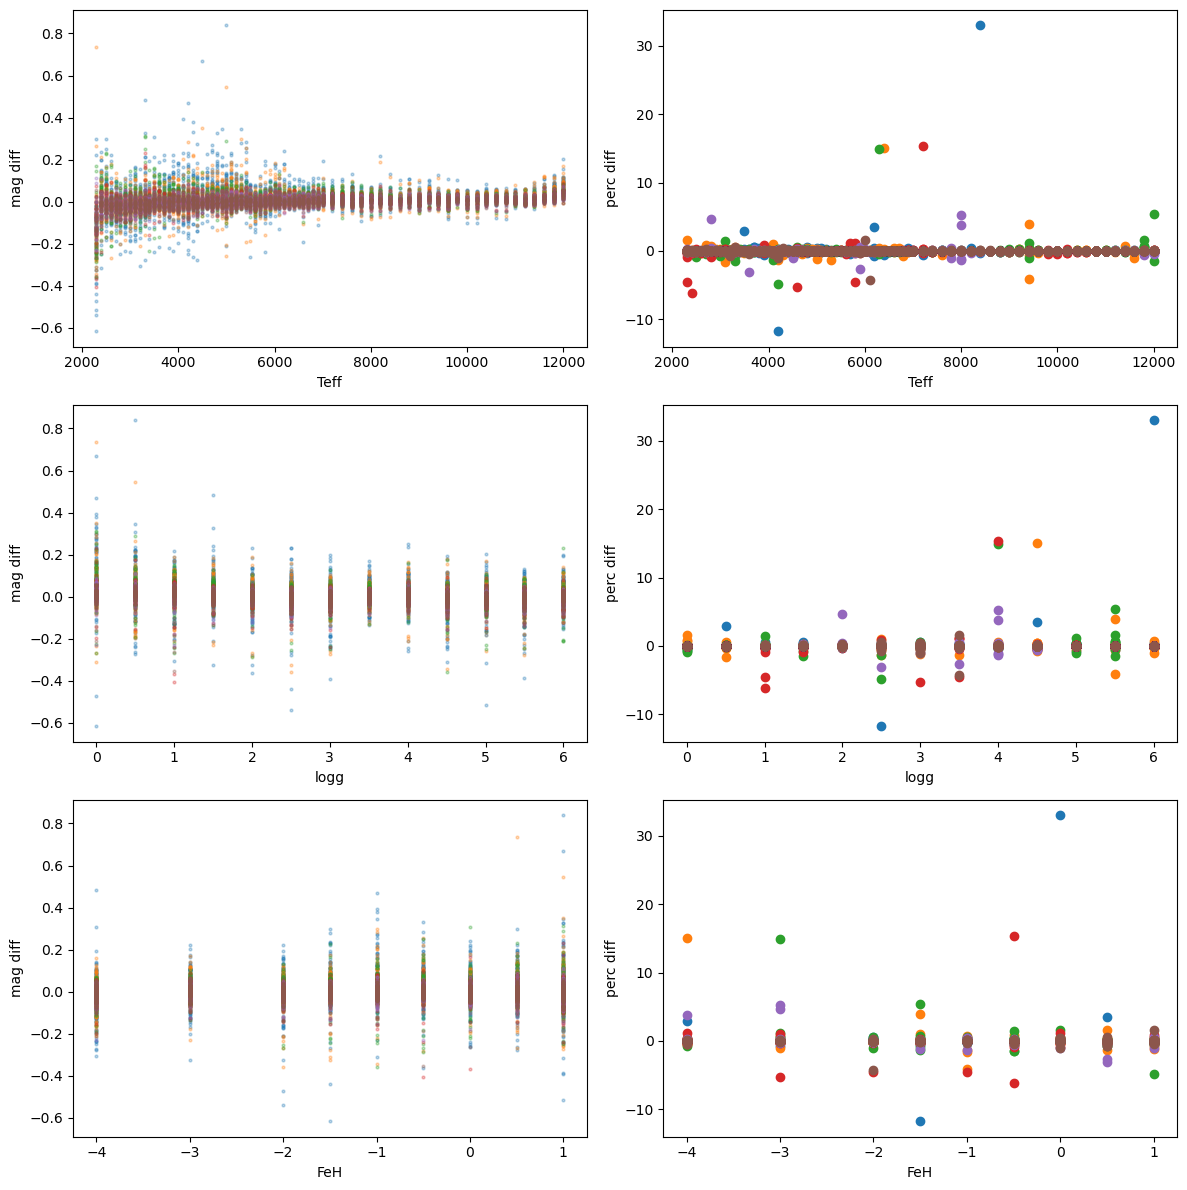

In [18]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

With pre-scaled?

5.101478 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

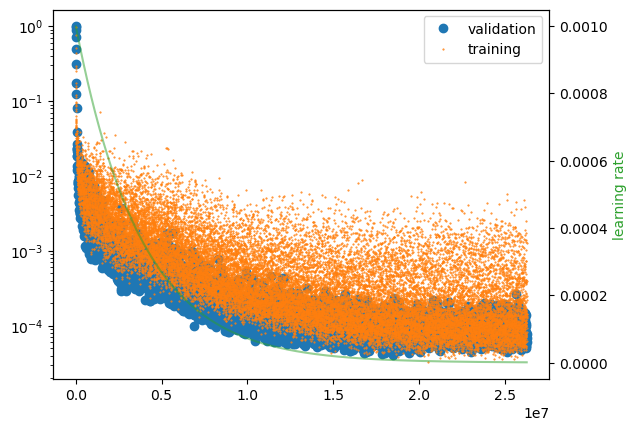

In [19]:
nepochs = 5000
startlr = 1e-3
endlr = 1e-6

model = PhotEmulator(feature_mlp_nneurons=[3, 8,   16, 64, 128, 256, 1024, 2048], 
                         phot_nneurons=[2048, 1024, 512, 128,  6], logifyteff=False, batchnorm=True)
print(sum(p.shape.numel() for p in model5.parameters()) * 1e-6, 'M parameters')
model6 = model

model = model.to(device, dtype=tensor_dtype)

gamma = (endlr/startlr)**(1/nepochs)
model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)

valid, train, lrs, data_split =  model.train_and_validate(infeaturesstded, scaled_phottensors, nepochs, int(np.ceil(infeatures.shape[0]/6)),
                                                         optkwargs=dict(lr=startlr, weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(0.00027026373), np.float32(0.008233977))

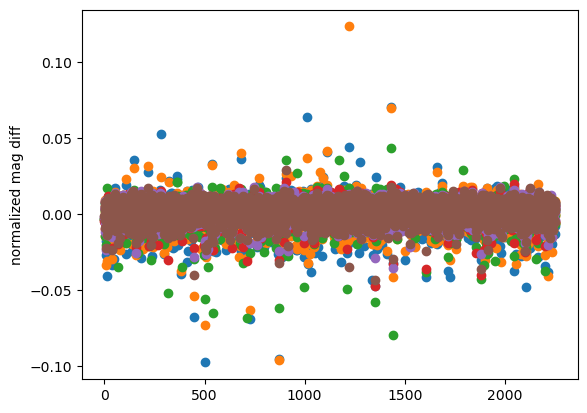

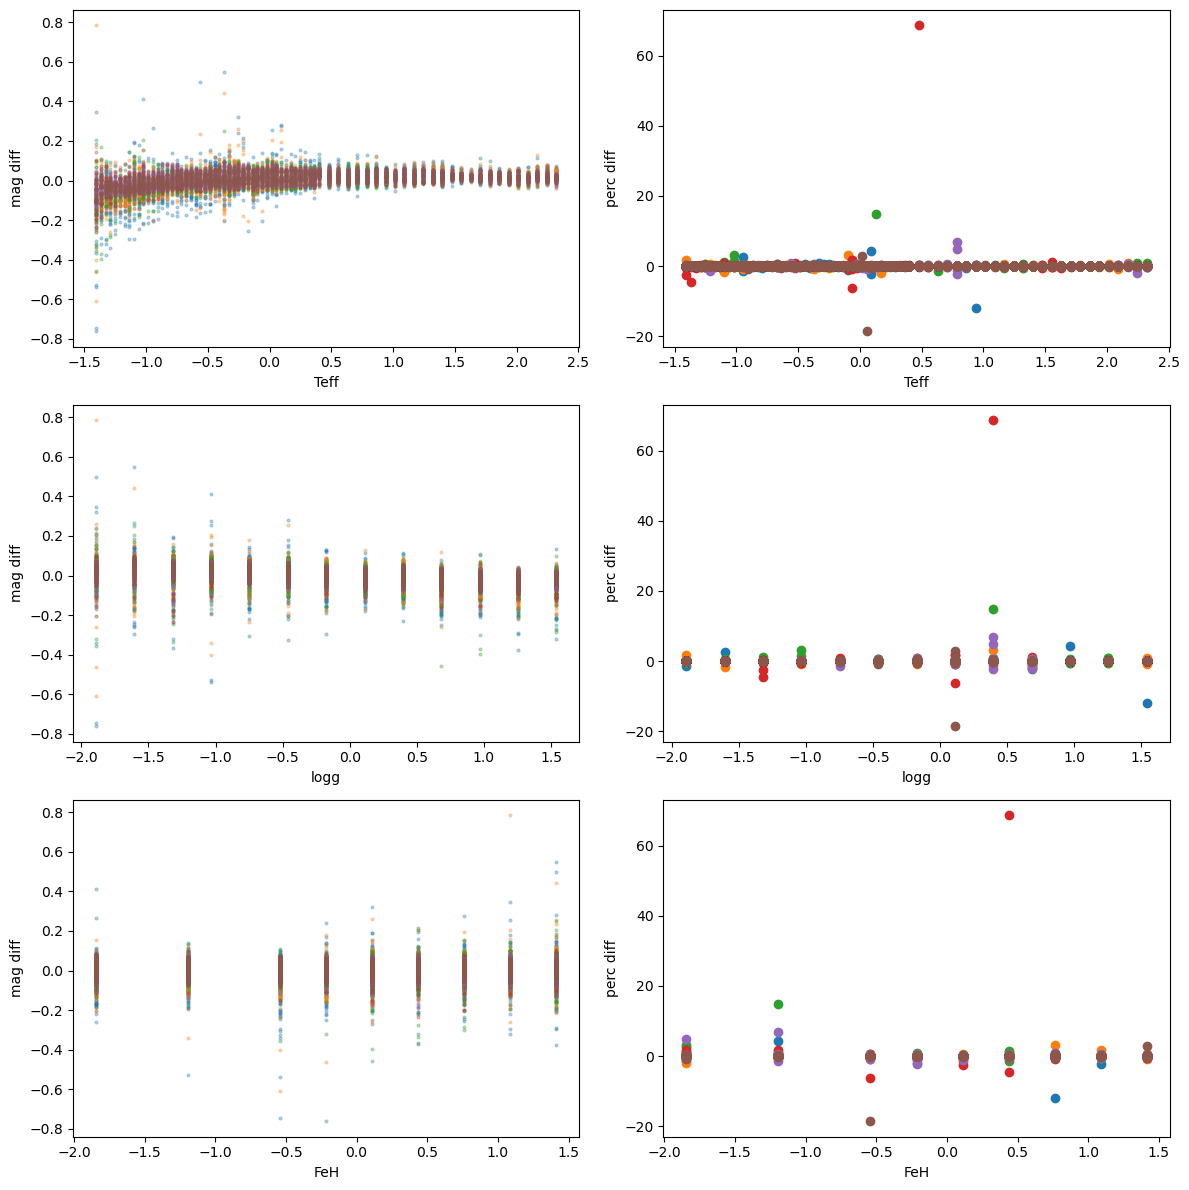

In [20]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())

# Manually scaling shallow network

1.0598459999999998 M parameters


  0%|          | 0/10000 [00:00<?, ?it/s]

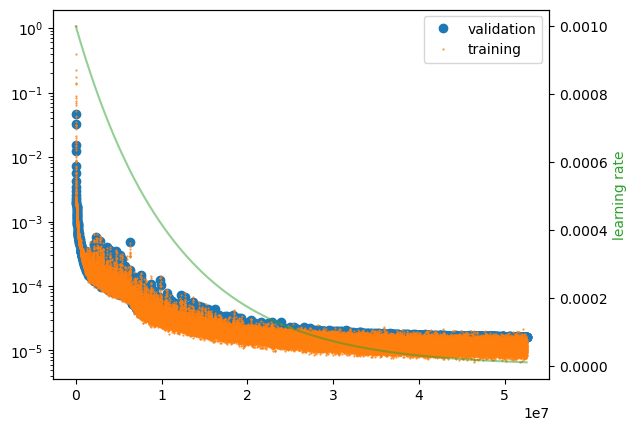

In [14]:
nrestarts = 0
nperrestart = 10000
nepochs = nperrestart if nrestarts == 0 else (nperrestart * nrestarts)


startlr = 1e-3
endlr = 1e-5

model = PhotEmulator(feature_mlp_nneurons=[3, 1024], 
                         phot_nneurons=[1024, 1024,  6], logifyteff=False, batchnorm=False)
print(sum(p.shape.numel() for p in model.parameters()) * 1e-6, 'M parameters')

model = model.to(device, dtype=tensor_dtype)

model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
if nrestarts == 0:
    gamma = (endlr/startlr)**(1/nepochs)
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=gamma)
else:
    model.scheduler_init = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
    

valid, train, lrs, data_split =  model.train_and_validate(infeaturesstded, scaled_phottensors, nepochs, int(np.ceil(infeatures.shape[0]/10)),
                                                         optkwargs=dict(lr=startlr, weight_decay=0))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')


(np.float32(-0.00024827453), np.float32(0.0040291073))

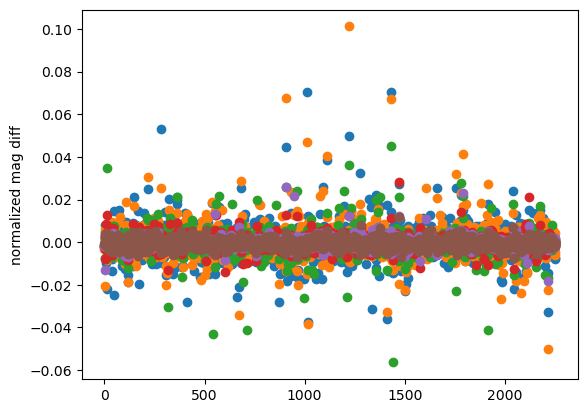

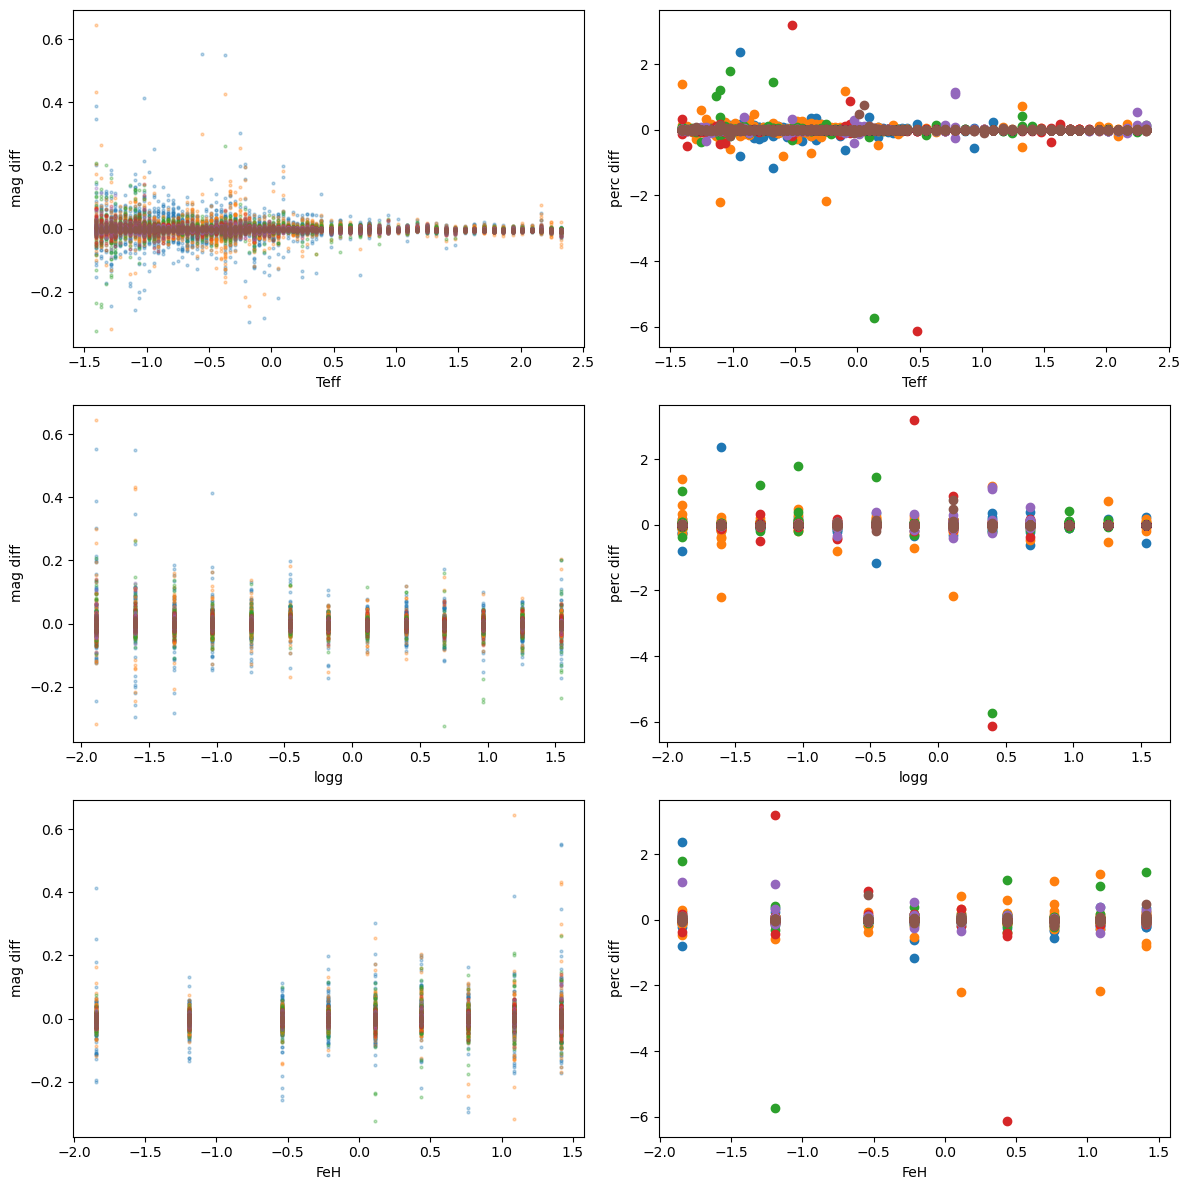

In [15]:
v = data_split[0]
X, Y = v.dataset[v.indices]
pred = model(X)

diff = (pred-Y)
percdiff = diff/Y

plt.plot(diff.cpu().detach(), 'o')
plt.ylabel('normalized mag diff')

ptscale = phottensors.std(0).cpu()

fig, axs = plt.subplots(X.shape[1], 2, figsize=(12, 12))
for inf, nm, ax in zip(X.T, infeature_names, axs):
    ax1, ax2 = ax
    ax1.plot(inf.cpu(), diff.cpu().detach() * ptscale, 'o', alpha=.3, lw=0, ms=2)
    ax1.set_xlabel(nm)
    ax1.set_ylabel('mag diff')
    ax2.plot(inf.cpu(), percdiff.cpu().detach(), 'o')
    ax2.set_xlabel(nm)
    ax2.set_ylabel('perc diff')

fig.tight_layout()

np.mean(diff.cpu().detach().numpy()),np.std(diff.cpu().detach().numpy())